# MADDPG

### Imports

In [1]:
import numpy as np
from pettingzoo.atari import boxing_v2
import numpy as np
import random 
import torch
import torch.nn as nn
import torch.optim as optim
from supersuit import pad_observations_v0, pad_action_space_v0, resize_v1, normalize_obs_v0, frame_skip_v0, dtype_v0
from pettingzoo.utils import aec_to_parallel
import matplotlib.pyplot as plt
from collections import defaultdict

## Critic and Actor Class

In [2]:
class Critic(nn.Module):
    def __init__(self, obs_dim, action_dim):
        super(Critic, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(obs_dim + action_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )

    def forward(self, obs, actions):
        # Ensure observations are flattened
        obs = obs.flatten(start_dim=1) if len(obs.shape) > 2 else obs
        actions = actions.flatten(start_dim=1) if len(actions.shape) > 2 else actions

        # Debugging shapes
        #print(f"obs shape: {obs.shape}, actions shape: {actions.shape}")

        x = torch.cat([obs, actions], dim=-1)
        return self.fc(x)
    
class Actor(nn.Module):
    def __init__(self, obs_dim, action_dim):
        super(Actor, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(obs_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim),
            nn.Tanh(),
        )

    def forward(self, obs):
        return self.fc(obs)

## MADDPG Agent

In [3]:
class MADDPGAgent:
    def __init__(self, obs_dim, action_dim, lr_actor=1e-3, lr_critic=1e-3):
        self.actor = Actor(obs_dim, action_dim)
        self.critic = Critic(obs_dim * 2, action_dim * 2)
        self.actor_target = Actor(obs_dim, action_dim)
        self.critic_target = Critic(obs_dim * 2, action_dim * 2)

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_critic)

        self.update_target(1.0)

    def update_target(self, tau):
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

## MADDPG Wrapper

In [4]:
class MADDPG:
    def __init__(self, obs_dim, action_dim, n_agents, gamma=0.95, tau=0.01):
        self.agents = [MADDPGAgent(obs_dim, action_dim) for _ in range(n_agents)]
        self.gamma = gamma
        self.tau = tau

    def update(self, replay_buffer, batch_size):
        policy_loss = 0
        value_loss = 0

        for agent_idx, agent in enumerate(self.agents):
            obs, actions, rewards, next_obs, dones = replay_buffer.sample(batch_size)
            obs = torch.tensor(obs, dtype=torch.float32).flatten(start_dim=2)  # Flatten observations
            actions = torch.tensor(actions, dtype=torch.float32).flatten(start_dim=2)  # Flatten actions

            rewards = torch.tensor(rewards[:, agent_idx], dtype=torch.float32).unsqueeze(-1)
            next_obs = torch.tensor(next_obs, dtype=torch.float32).flatten(start_dim=2)
            dones = torch.tensor(dones[:, agent_idx], dtype=torch.float32).unsqueeze(-1)

            # Critic update
            with torch.no_grad():
                next_actions = torch.cat([
                    ag.actor_target(next_obs[:, i]) for i, ag in enumerate(self.agents)
                ], dim=-1)
                target_q = rewards + self.gamma * (1 - dones) * agent.critic_target(next_obs, next_actions)

            q_value = agent.critic(obs, actions)
            critic_loss = nn.MSELoss()(q_value, target_q)
            agent.critic_optimizer.zero_grad()
            critic_loss.backward()
            agent.critic_optimizer.step()
            value_loss += critic_loss.item()

            # Actor update
            predicted_actions = torch.cat([
                agent.actor(obs[:, i]) if i == agent_idx else actions[:, i] for i, _ in enumerate(self.agents)
            ], dim=-1)
            actor_loss = -agent.critic(obs, predicted_actions).mean()
            agent.actor_optimizer.zero_grad()
            actor_loss.backward()
            agent.actor_optimizer.step()
            policy_loss += actor_loss.item()

            # Update targets
            agent.update_target(self.tau)

        return policy_loss / len(self.agents), value_loss / len(self.agents)

## Buffer

In [5]:
class ReplayBuffer:
    def __init__(self, max_size, obs_dim, action_dim, n_agents):
        self.max_size = max_size
        self.ptr = 0
        self.size = 0
        self.obs = np.zeros((max_size, n_agents, obs_dim))
        self.actions = np.zeros((max_size, n_agents, action_dim))
        self.rewards = np.zeros((max_size, n_agents))
        self.next_obs = np.zeros((max_size, n_agents, obs_dim))
        self.dones = np.zeros((max_size, n_agents))

    def store(self, obs, actions, rewards, next_obs, dones):
        self.obs[self.ptr] = obs
        self.actions[self.ptr] = actions
        self.rewards[self.ptr] = rewards
        self.next_obs[self.ptr] = next_obs
        self.dones[self.ptr] = dones
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        idx = np.random.choice(self.size, batch_size, replace=False)
        return (
            self.obs[idx],
            self.actions[idx],
            self.rewards[idx],
            self.next_obs[idx],
            self.dones[idx],
        )

## Environment setup

In [6]:
# Environment setup
env = boxing_v2.env(render_mode="rgb_array")
env.reset(seed=42)
env = pad_observations_v0(env)
env = pad_action_space_v0(env)
env = resize_v1(env, 84, 84)
env = dtype_v0(env, dtype="float32")
env = normalize_obs_v0(env, env_min=0, env_max=1)
parallel_env = aec_to_parallel(env)

obs_dim = 84 * 84
action_dim = parallel_env.action_space("first_0").n
n_agents = 2
maddpg = MADDPG(obs_dim, action_dim, n_agents)
replay_buffer = ReplayBuffer(100000, obs_dim, action_dim, n_agents)

## Training loop

In [13]:
# Training loop
num_episodes = 10
batch_size = 64

max_steps_per_episode = 100  # Set the maximum steps per episode
for episode in range(num_episodes):
    obs = parallel_env.reset()
    if isinstance(obs, tuple):
        obs = obs[0]  # Extract observations if returned as a tuple

    done = {agent: False for agent in parallel_env.agents}
    episode_reward = defaultdict(float)  # Store cumulative reward for each agent

    step_count = 0  # Initialize step counter

    while not all(done.values()) and step_count < max_steps_per_episode:
        actions = {}
        for agent in parallel_env.agents:
            # Preprocess observation
            obs_preprocessed = torch.tensor(obs[agent], dtype=torch.float32)
            if len(obs_preprocessed.shape) > 2:  # Ensure grayscale
                obs_preprocessed = obs_preprocessed.mean(axis=-1)  # Convert RGB to grayscale
            obs_preprocessed = obs_preprocessed.flatten().unsqueeze(0)  # Flatten and add batch dim

            # Get continuous action from Actor
            continuous_action = maddpg.agents[int(agent.split('_')[1])].actor(obs_preprocessed).detach().numpy()

            # Convert continuous action to discrete action
            discrete_action = np.argmax(continuous_action)  # Take the action with the highest probability
            actions[agent] = discrete_action  # Store the discrete action for the agent

        # One-hot encode actions for storage
        actions_one_hot = np.zeros((len(parallel_env.agents), action_dim))
        for idx, agent in enumerate(parallel_env.agents):
            actions_one_hot[idx, actions[agent]] = 1

        # Step the environment
        step_output = parallel_env.step(actions)

        if isinstance(step_output, tuple):  # Handle cases where step returns a tuple
            next_obs, rewards, dones, truncations, infos = step_output
            dones = {agent: dones[agent] or truncations[agent] for agent in dones}
        else:
            next_obs, rewards, dones, infos = step_output

        # Accumulate rewards
        for agent, reward in rewards.items():
            episode_reward[agent] += reward

        # Store data in the replay buffer
        obs_array = []
        next_obs_array = []

        for agent in parallel_env.agents:
            # Preprocess observations for storage
            obs_processed = obs[agent].mean(axis=-1).flatten() if len(obs[agent].shape) > 2 else obs[agent].flatten()
            next_obs_processed = next_obs[agent].mean(axis=-1).flatten() if len(next_obs[agent].shape) > 2 else next_obs[agent].flatten()
            obs_array.append(obs_processed)
            next_obs_array.append(next_obs_processed)

        replay_buffer.store(
            np.array(obs_array),
            actions_one_hot,  # Use one-hot encoded actions
            np.array([rewards[agent] for agent in parallel_env.agents]),
            np.array(next_obs_array),
            np.array([dones[agent] for agent in parallel_env.agents]),
        )

        obs = next_obs

        if replay_buffer.size >= batch_size:
            policy_loss, value_loss = maddpg.update(replay_buffer, batch_size)
            print(f"Policy Loss: {policy_loss}, Value Loss: {value_loss}")

        step_count += 1  # Increment step count

    # Print cumulative reward for the episode
    total_reward = sum(episode_reward.values())
    print(f"Episode {episode + 1}/{num_episodes} completed with total reward: {total_reward}")


Policy Loss: -0.17359518678858876, Value Loss: 5.859720113221556e-05
Policy Loss: -0.1754363370127976, Value Loss: 0.000234179893595865
Policy Loss: -0.17963051283732057, Value Loss: 0.00025242687479476444
Policy Loss: -0.1724323844537139, Value Loss: 7.117877248674631e-05
Policy Loss: -0.16031982749700546, Value Loss: 7.12306318746414e-05
Policy Loss: -0.16267995815724134, Value Loss: 0.00018309837469132617
Policy Loss: -0.17731905914843082, Value Loss: 0.0001348505902569741
Policy Loss: -0.18409174028784037, Value Loss: 2.7931535896641435e-05
Policy Loss: -0.18013833835721016, Value Loss: 7.954859393066727e-05
Policy Loss: -0.17830464569851756, Value Loss: 0.000130353873828426
Policy Loss: -0.17940067034214735, Value Loss: 5.299672739056405e-05
Policy Loss: -0.1751910988241434, Value Loss: 2.4324501282535493e-05
Policy Loss: -0.1706725051626563, Value Loss: 7.271702816069592e-05
Policy Loss: -0.17681840062141418, Value Loss: 7.935226494737435e-05
Policy Loss: -0.18684775102883577, Va

KeyboardInterrupt: 

Episode 1/30 completed with total reward: 0.0, Total Loss: -9.472727838390162
Episode 2/30 completed with total reward: 0.0, Total Loss: -9.272694775922105
Episode 3/30 completed with total reward: 0.0, Total Loss: -8.988100596469101
Episode 4/30 completed with total reward: 0.0, Total Loss: -8.847783310707563
Episode 5/30 completed with total reward: 0.0, Total Loss: -8.654771053341438
Episode 6/30 completed with total reward: 0.0, Total Loss: -8.466184665947482
Episode 7/30 completed with total reward: 0.0, Total Loss: -8.291770481918148
Episode 8/30 completed with total reward: 0.0, Total Loss: -7.985007055572987
Episode 9/30 completed with total reward: 0.0, Total Loss: -7.833614682203307
Episode 10/30 completed with total reward: 0.0, Total Loss: -7.668229397509033
Episode 11/30 completed with total reward: 0.0, Total Loss: -7.508503085138606
Episode 12/30 completed with total reward: 0.0, Total Loss: -7.251800697686379
Episode 13/30 completed with total reward: 0.0, Total Loss: -

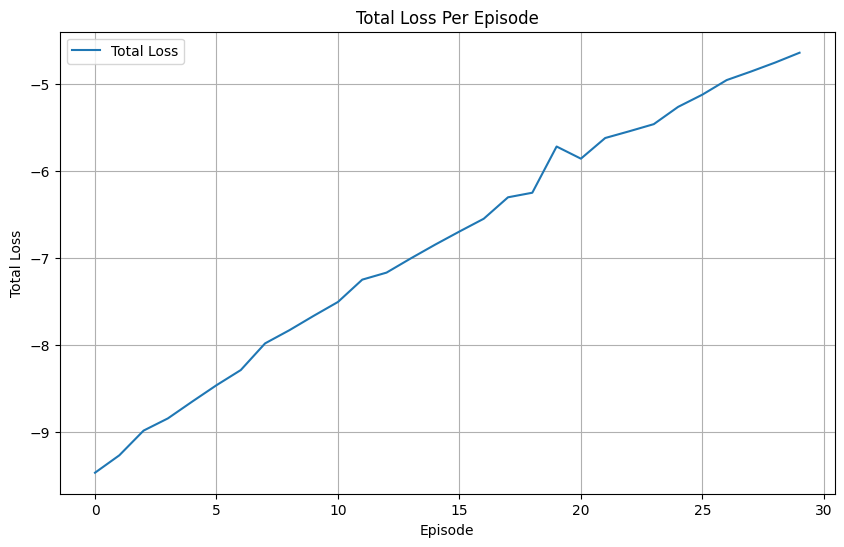

In [14]:
# Training loop
num_episodes = 30
batch_size = 64

max_steps_per_episode = 50  # Set the maximum steps per episode
import matplotlib.pyplot as plt

# Track total loss per episode
total_loss_per_episode = []

for episode in range(num_episodes):
    obs = parallel_env.reset()
    if isinstance(obs, tuple):
        obs = obs[0]  # Extract observations if returned as a tuple

    done = {agent: False for agent in parallel_env.agents}
    episode_reward = defaultdict(float)  # Store cumulative reward for each agent

    step_count = 0  # Initialize step counter
    episode_policy_loss = 0  # Accumulate policy loss
    episode_value_loss = 0  # Accumulate value loss

    while not all(done.values()) and step_count < max_steps_per_episode:
        actions = {}
        for agent in parallel_env.agents:
            # Preprocess observation
            obs_preprocessed = torch.tensor(obs[agent], dtype=torch.float32)
            if len(obs_preprocessed.shape) > 2:  # Ensure grayscale
                obs_preprocessed = obs_preprocessed.mean(axis=-1)  # Convert RGB to grayscale
            obs_preprocessed = obs_preprocessed.flatten().unsqueeze(0)  # Flatten and add batch dim

            # Get continuous action from Actor
            continuous_action = maddpg.agents[int(agent.split('_')[1])].actor(obs_preprocessed).detach().numpy()

            # Convert continuous action to discrete action
            discrete_action = np.argmax(continuous_action)  # Take the action with the highest probability
            actions[agent] = discrete_action  # Store the discrete action for the agent

        # One-hot encode actions for storage
        actions_one_hot = np.zeros((len(parallel_env.agents), action_dim))
        for idx, agent in enumerate(parallel_env.agents):
            actions_one_hot[idx, actions[agent]] = 1

        # Step the environment
        step_output = parallel_env.step(actions)

        if isinstance(step_output, tuple):  # Handle cases where step returns a tuple
            next_obs, rewards, dones, truncations, infos = step_output
            dones = {agent: dones[agent] or truncations[agent] for agent in dones}
        else:
            next_obs, rewards, dones, infos = step_output

        # Accumulate rewards
        for agent, reward in rewards.items():
            episode_reward[agent] += reward

        # Store data in the replay buffer
        obs_array = []
        next_obs_array = []

        for agent in parallel_env.agents:
            # Preprocess observations for storage
            obs_processed = obs[agent].mean(axis=-1).flatten() if len(obs[agent].shape) > 2 else obs[agent].flatten()
            next_obs_processed = next_obs[agent].mean(axis=-1).flatten() if len(next_obs[agent].shape) > 2 else next_obs[agent].flatten()
            obs_array.append(obs_processed)
            next_obs_array.append(next_obs_processed)

        replay_buffer.store(
            np.array(obs_array),
            actions_one_hot,  # Use one-hot encoded actions
            np.array([rewards[agent] for agent in parallel_env.agents]),
            np.array(next_obs_array),
            np.array([dones[agent] for agent in parallel_env.agents]),
        )

        obs = next_obs

        if replay_buffer.size >= batch_size:
            policy_loss, value_loss = maddpg.update(replay_buffer, batch_size)
            episode_policy_loss += policy_loss
            episode_value_loss += value_loss

        step_count += 1  # Increment step count

    # Record total loss for this episode
    total_loss = episode_policy_loss + episode_value_loss
    total_loss_per_episode.append(total_loss)

    # Print cumulative reward and total loss for the episode
    total_reward = sum(episode_reward.values())
    print(f"Episode {episode + 1}/{num_episodes} completed with total reward: {total_reward}, Total Loss: {total_loss}")

# Plot total loss per episode
plt.figure(figsize=(10, 6))
plt.plot(total_loss_per_episode, label='Total Loss')
plt.xlabel('Episode')
plt.ylabel('Total Loss')
plt.title('Total Loss Per Episode')
plt.legend()
plt.grid(True)
plt.show()


### Try to track agent rewards separately

Episode 1/6 completed
  first_0 Reward: 0.0
  second_0 Reward: 0.0
  Total Loss: 157.77606607041687
Episode 1/6 completed in 351.40 seconds
Episode 2/6 completed
  first_0 Reward: 0.0
  second_0 Reward: 0.0
  Total Loss: 86.5786312672517
Episode 2/6 completed in 374.47 seconds
Episode 3/6 completed
  first_0 Reward: 0.0
  second_0 Reward: 0.0
  Total Loss: 43.49052276886123
Episode 3/6 completed in 374.27 seconds
Episode 4/6 completed
  first_0 Reward: 0.0
  second_0 Reward: 0.0
  Total Loss: 19.464231006591895
Episode 4/6 completed in 374.08 seconds
Episode 5/6 completed
  first_0 Reward: 0.0
  second_0 Reward: 0.0
  Total Loss: 5.522323497176852
Episode 5/6 completed in 373.26 seconds
Episode 6/6 completed
  first_0 Reward: 0.0
  second_0 Reward: 0.0
  Total Loss: 6.522291655597713
Episode 6/6 completed in 372.90 seconds


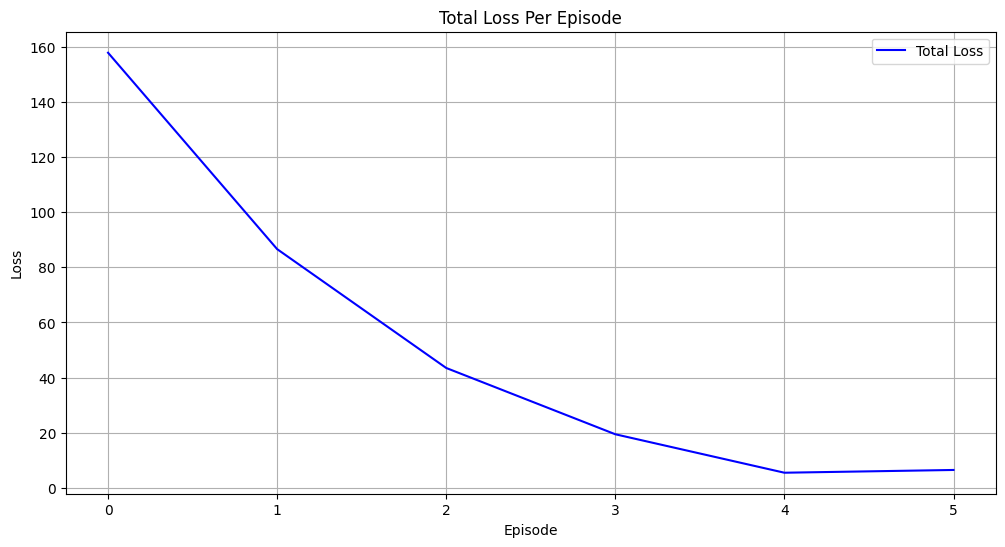

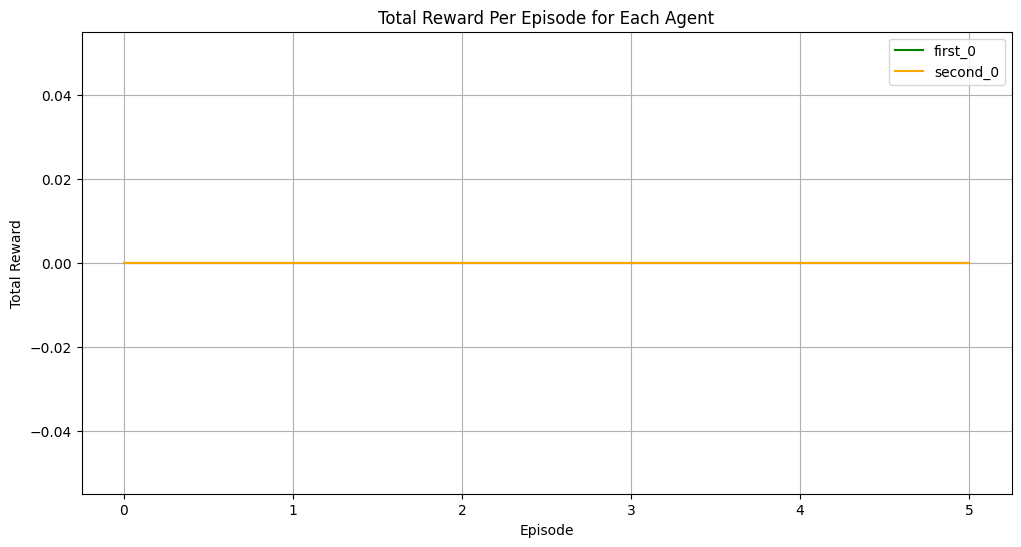

In [15]:
import matplotlib.pyplot as plt
from collections import defaultdict
import time

# Training parameters
num_episodes = 6
batch_size = 64
max_steps_per_episode = 1000 # maybe 30-45 seconds per 100 steps

# Track total loss and rewards per episode
total_loss_per_episode = []
agent1_rewards = []  # Rewards for the first agent
agent2_rewards = []  # Rewards for the second agent

for episode in range(num_episodes):
    # Start timing the episode
    start_time = time.time()

    obs = parallel_env.reset()
    if isinstance(obs, tuple):
        obs = obs[0]  # Extract observations if returned as a tuple

    done = {agent: False for agent in parallel_env.agents}
    episode_reward = defaultdict(float)  # Store cumulative reward for each agent

    step_count = 0  # Initialize step counter
    episode_policy_loss = 0  # Accumulate policy loss
    episode_value_loss = 0  # Accumulate value loss

    while not all(done.values()) and step_count < max_steps_per_episode:
        actions = {}
        for agent in parallel_env.agents:
            # Preprocess observation
            obs_preprocessed = torch.tensor(obs[agent], dtype=torch.float32)
            if len(obs_preprocessed.shape) > 2:  # Ensure grayscale
                obs_preprocessed = obs_preprocessed.mean(axis=-1)  # Convert RGB to grayscale
            obs_preprocessed = obs_preprocessed.flatten().unsqueeze(0)  # Flatten and add batch dim

            # Get continuous action from Actor
            continuous_action = maddpg.agents[int(agent.split('_')[1])].actor(obs_preprocessed).detach().numpy()

            # Convert continuous action to discrete action
            discrete_action = np.argmax(continuous_action)  # Take the action with the highest probability
            actions[agent] = discrete_action  # Store the discrete action for the agent

        # One-hot encode actions for storage
        actions_one_hot = np.zeros((len(parallel_env.agents), action_dim))
        for idx, agent in enumerate(parallel_env.agents):
            actions_one_hot[idx, actions[agent]] = 1

        # Step the environment
        step_output = parallel_env.step(actions)

        if isinstance(step_output, tuple):  # Handle cases where step returns a tuple
            next_obs, rewards, dones, truncations, infos = step_output
            dones = {agent: dones[agent] or truncations[agent] for agent in dones}
        else:
            next_obs, rewards, dones, infos = step_output

        # Accumulate rewards for each agent
        for agent, reward in rewards.items():
            episode_reward[agent] += reward

        # Store data in the replay buffer
        obs_array = []
        next_obs_array = []

        for agent in parallel_env.agents:
            # Preprocess observations for storage
            obs_processed = obs[agent].mean(axis=-1).flatten() if len(obs[agent].shape) > 2 else obs[agent].flatten()
            next_obs_processed = next_obs[agent].mean(axis=-1).flatten() if len(next_obs[agent].shape) > 2 else next_obs[agent].flatten()
            obs_array.append(obs_processed)
            next_obs_array.append(next_obs_processed)

        replay_buffer.store(
            np.array(obs_array),
            actions_one_hot,  # Use one-hot encoded actions
            np.array([rewards[agent] for agent in parallel_env.agents]),
            np.array(next_obs_array),
            np.array([dones[agent] for agent in parallel_env.agents]),
        )

        obs = next_obs

        if replay_buffer.size >= batch_size:
            policy_loss, value_loss = maddpg.update(replay_buffer, batch_size)
            episode_policy_loss += policy_loss
            episode_value_loss += value_loss

        step_count += 1  # Increment step count

    # Record total loss for this episode
    total_loss = episode_policy_loss + episode_value_loss
    total_loss_per_episode.append(total_loss)

    # Separate rewards for each agent
    agent1_reward = episode_reward[parallel_env.agents[0]]
    agent2_reward = episode_reward[parallel_env.agents[1]]

    # Append rewards to lists
    agent1_rewards.append(agent1_reward)
    agent2_rewards.append(agent2_reward)

    # Print cumulative reward and total loss for the episode
    print(f"Episode {episode + 1}/{num_episodes} completed")
    print(f"  {parallel_env.agents[0]} Reward: {agent1_reward}")
    print(f"  {parallel_env.agents[1]} Reward: {agent2_reward}")
    print(f"  Total Loss: {total_loss}")

    # End timing the episode
    end_time = time.time()
    episode_duration = end_time - start_time

    # Print the duration
    print(f"Episode {episode + 1}/{num_episodes} completed in {episode_duration:.2f} seconds")

# Plot total loss per episode
plt.figure(figsize=(12, 6))
plt.plot(total_loss_per_episode, label='Total Loss', color='blue')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Total Loss Per Episode')
plt.legend()
plt.grid(True)
plt.show()

# Plot rewards for both agents
plt.figure(figsize=(12, 6))
plt.plot(agent1_rewards, label=parallel_env.agents[0], color='green')
plt.plot(agent2_rewards, label=parallel_env.agents[1], color='orange')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward Per Episode for Each Agent')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
print(rewards)


defaultdict(<class 'int'>, {'first_0': 0, 'second_0': 0})


In [17]:
print(f"Actions taken by agents: {actions}")


Actions taken by agents: {'first_0': 0, 'second_0': 0}


In [19]:
agent1_rewards

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

### Print actions in a step

In [21]:
import matplotlib.pyplot as plt
from collections import defaultdict
import time

# Training parameters
num_episodes = 6
batch_size = 64
max_steps_per_episode = 50  # maybe 30-45 seconds per 100 steps

# Track total loss and rewards per episode
total_loss_per_episode = []
agent1_rewards = []  # Rewards for the first agent
agent2_rewards = []  # Rewards for the second agent

for episode in range(num_episodes):
    # Start timing the episode
    start_time = time.time()

    obs = parallel_env.reset()
    if isinstance(obs, tuple):
        obs = obs[0]  # Extract observations if returned as a tuple

    done = {agent: False for agent in parallel_env.agents}
    episode_reward = defaultdict(float)  # Store cumulative reward for each agent

    step_count = 0  # Initialize step counter
    episode_policy_loss = 0  # Accumulate policy loss
    episode_value_loss = 0  # Accumulate value loss

    while not all(done.values()) and step_count < max_steps_per_episode:
        actions = {}
        for agent in parallel_env.agents:
            # Preprocess observation
            obs_preprocessed = torch.tensor(obs[agent], dtype=torch.float32)
            if len(obs_preprocessed.shape) > 2:  # Ensure grayscale
                obs_preprocessed = obs_preprocessed.mean(axis=-1)  # Convert RGB to grayscale
            obs_preprocessed = obs_preprocessed.flatten().unsqueeze(0)  # Flatten and add batch dim

            # Get continuous action from Actor
            continuous_action = maddpg.agents[int(agent.split('_')[1])].actor(obs_preprocessed).detach().numpy()

            # Convert continuous action to discrete action
            discrete_action = np.argmax(continuous_action)  # Take the action with the highest probability
            actions[agent] = discrete_action  # Store the discrete action for the agent

        # Print actions for debugging
        print(f"Step {step_count + 1} Actions:")
        for agent, action in actions.items():
            print(f"  {agent}: Action {action}")

        # One-hot encode actions for storage
        actions_one_hot = np.zeros((len(parallel_env.agents), action_dim))
        for idx, agent in enumerate(parallel_env.agents):
            actions_one_hot[idx, actions[agent]] = 1

        # Step the environment
        step_output = parallel_env.step(actions)

        if isinstance(step_output, tuple):  # Handle cases where step returns a tuple
            next_obs, rewards, dones, truncations, infos = step_output
            dones = {agent: dones[agent] or truncations[agent] for agent in dones}
        else:
            next_obs, rewards, dones, infos = step_output

        # Accumulate rewards for each agent
        for agent, reward in rewards.items():
            episode_reward[agent] += reward

        # Print rewards for debugging
        print(f"Step {step_count + 1} Rewards:")
        for agent, reward in rewards.items():
            print(f"  {agent}: Reward {reward}")

        # Store data in the replay buffer
        obs_array = []
        next_obs_array = []

        for agent in parallel_env.agents:
            # Preprocess observations for storage
            obs_processed = obs[agent].mean(axis=-1).flatten() if len(obs[agent].shape) > 2 else obs[agent].flatten()
            next_obs_processed = next_obs[agent].mean(axis=-1).flatten() if len(next_obs[agent].shape) > 2 else next_obs[agent].flatten()
            obs_array.append(obs_processed)
            next_obs_array.append(next_obs_processed)

        replay_buffer.store(
            np.array(obs_array),
            actions_one_hot,  # Use one-hot encoded actions
            np.array([rewards[agent] for agent in parallel_env.agents]),
            np.array(next_obs_array),
            np.array([dones[agent] for agent in parallel_env.agents]),
        )

        obs = next_obs

        if replay_buffer.size >= batch_size:
            policy_loss, value_loss = maddpg.update(replay_buffer, batch_size)
            episode_policy_loss += policy_loss
            episode_value_loss += value_loss

        step_count += 1  # Increment step count

    # Record total loss for this episode
    total_loss = episode_policy_loss + episode_value_loss
    total_loss_per_episode.append(total_loss)

    # Separate rewards for each agent
    agent1_reward = episode_reward[parallel_env.agents[0]]
    agent2_reward = episode_reward[parallel_env.agents[1]]

    # Append rewards to lists
    agent1_rewards.append(agent1_reward)
    agent2_rewards.append(agent2_reward)

    # Print cumulative reward and total loss for the episode
    print(f"Episode {episode + 1}/{num_episodes} completed")
    print(f"  {parallel_env.agents[0]} Reward: {agent1_reward}")
    print(f"  {parallel_env.agents[1]} Reward: {agent2_reward}")
    print(f"  Total Loss: {total_loss}")

    # End timing the episode
    end_time = time.time()
    episode_duration = end_time - start_time

    # Print the duration
    print(f"Episode {episode + 1}/{num_episodes} completed in {episode_duration:.2f} seconds")


Step 1 Actions:
  first_0: Action 12
  second_0: Action 12
Step 1 Rewards:
  first_0: Reward 0
  second_0: Reward 0
Step 2 Actions:
  first_0: Action 12
  second_0: Action 12
Step 2 Rewards:
  first_0: Reward 0
  second_0: Reward 0
Step 3 Actions:
  first_0: Action 12
  second_0: Action 12
Step 3 Rewards:
  first_0: Reward 0
  second_0: Reward 0
Step 4 Actions:
  first_0: Action 12
  second_0: Action 12
Step 4 Rewards:
  first_0: Reward 0
  second_0: Reward 0
Step 5 Actions:
  first_0: Action 12
  second_0: Action 12
Step 5 Rewards:
  first_0: Reward 0
  second_0: Reward 0
Step 6 Actions:
  first_0: Action 12
  second_0: Action 12
Step 6 Rewards:
  first_0: Reward 0
  second_0: Reward 0
Step 7 Actions:
  first_0: Action 12
  second_0: Action 12
Step 7 Rewards:
  first_0: Reward 0
  second_0: Reward 0
Step 8 Actions:
  first_0: Action 12
  second_0: Action 12
Step 8 Rewards:
  first_0: Reward 0
  second_0: Reward 0
Step 9 Actions:
  first_0: Action 12
  second_0: Action 12
Step 9 Reward

### Render using pettingzoo Atari human
### 1000 steps is only about 17 seconds in gametime!!!
### 3000 steps is about 51 seconds in gametime

In [23]:
from pettingzoo.atari import boxing_v2
from supersuit import pad_observations_v0, pad_action_space_v0, resize_v1, normalize_obs_v0, dtype_v0

# Initialize the environment with human rendering
parallel_env = boxing_v2.parallel_env(render_mode="human")

# Preprocess the environment for compatibility with agents
parallel_env = pad_observations_v0(parallel_env)
parallel_env = pad_action_space_v0(parallel_env)
parallel_env = resize_v1(parallel_env, 84, 84)
parallel_env = dtype_v0(parallel_env, dtype="float32")
parallel_env = normalize_obs_v0(parallel_env, env_min=0, env_max=1)

# Reset the environment
obs = parallel_env.reset()

# Run for one episode, max 100 steps
max_steps = 3000
step_count = 0
done = {agent: False for agent in parallel_env.agents}  # Track done state for each agent

while not all(done.values()) and step_count < max_steps:
    actions = {}

    # Sample random actions for each agent (replace with learned actions if available)
    for agent in parallel_env.agents:
        actions[agent] = parallel_env.action_space(agent).sample()  # Replace with actual agent's action if needed

    # Step the environment
    step_output = parallel_env.step(actions)

    # Render the game
    parallel_env.render()  # This should pop up the Atari game window

    # Print rewards for debugging purposes
    if isinstance(step_output, tuple):  # Handle if step output is a tuple
        obs, rewards, dones, truncations, infos = step_output
        done = {agent: dones[agent] or truncations[agent] for agent in dones}
    else:
        obs, rewards, dones, infos = step_output

    print(f"Step {step_count + 1}:")
    for agent, reward in rewards.items():
        print(f"  {agent} Reward: {reward}")

    step_count += 1  # Increment step counter

print("Testing complete.")
parallel_env.close()  # Close the rendering window


Step 1:
  first_0 Reward: 0
  second_0 Reward: 0
Step 2:
  first_0 Reward: 0
  second_0 Reward: 0
Step 3:
  first_0 Reward: 0
  second_0 Reward: 0
Step 4:
  first_0 Reward: 0
  second_0 Reward: 0
Step 5:
  first_0 Reward: 0
  second_0 Reward: 0
Step 6:
  first_0 Reward: 0
  second_0 Reward: 0
Step 7:
  first_0 Reward: 0
  second_0 Reward: 0
Step 8:
  first_0 Reward: 0
  second_0 Reward: 0
Step 9:
  first_0 Reward: 0
  second_0 Reward: 0
Step 10:
  first_0 Reward: 0
  second_0 Reward: 0
Step 11:
  first_0 Reward: 0
  second_0 Reward: 0
Step 12:
  first_0 Reward: 0
  second_0 Reward: 0
Step 13:
  first_0 Reward: 0
  second_0 Reward: 0
Step 14:
  first_0 Reward: 0
  second_0 Reward: 0
Step 15:
  first_0 Reward: 0
  second_0 Reward: 0
Step 16:
  first_0 Reward: 0
  second_0 Reward: 0
Step 17:
  first_0 Reward: 0
  second_0 Reward: 0
Step 18:
  first_0 Reward: 0
  second_0 Reward: 0
Step 19:
  first_0 Reward: 0
  second_0 Reward: 0
Step 20:
  first_0 Reward: 0
  second_0 Reward: 0
Step 21:


### Human rendering MADDPG

In [22]:
# Environment setup for human rendering
env = boxing_v2.env(render_mode="human")  # Set render_mode to "human" for faster real-time rendering
env.reset(seed=42)
env = pad_observations_v0(env)
env = pad_action_space_v0(env)
env = resize_v1(env, 84, 84)
env = dtype_v0(env, dtype="float32")
env = normalize_obs_v0(env, env_min=0, env_max=1)
parallel_env = aec_to_parallel(env)

obs_dim = 84 * 84
action_dim = parallel_env.action_space("first_0").n
n_agents = 2
maddpg = MADDPG(obs_dim, action_dim, n_agents)
replay_buffer = ReplayBuffer(100000, obs_dim, action_dim, n_agents)


In [25]:
import time
from collections import defaultdict

# Training parameters
num_episodes = 1  # Render one episode for visualization
batch_size = 64
max_steps_per_episode = 1000

for episode in range(num_episodes):
    obs = parallel_env.reset()
    if isinstance(obs, tuple):
        obs = obs[0]  # Extract observations if returned as a tuple

    done = {agent: False for agent in parallel_env.agents}
    episode_reward = defaultdict(float)  # Store cumulative reward for each agent

    step_count = 0  # Initialize step counter
    start_time = time.time()  # Track start time

    while not all(done.values()) and step_count < max_steps_per_episode:
        actions = {}
        for agent in parallel_env.agents:
            # Preprocess observation
            obs_preprocessed = torch.tensor(obs[agent], dtype=torch.float32)
            if len(obs_preprocessed.shape) > 2:  # Ensure grayscale
                obs_preprocessed = obs_preprocessed.mean(axis=-1)  # Convert RGB to grayscale
            obs_preprocessed = obs_preprocessed.flatten().unsqueeze(0)  # Flatten and add batch dim

            # Get continuous action from Actor
            continuous_action = maddpg.agents[int(agent.split('_')[1])].actor(obs_preprocessed).detach().numpy()

            # Convert continuous action to discrete action
            discrete_action = np.argmax(continuous_action)  # Take the action with the highest probability
            actions[agent] = discrete_action  # Store the discrete action for the agent

            # Debug: Print observation and action for the agent
            print(f"Step {step_count + 1}, Agent {agent}")
            print(f"  Observation (flattened): {obs_preprocessed.flatten().numpy()[:10]}...")  # Print first 10 values
            print(f"  Continuous Action: {continuous_action}")
            print(f"  Discrete Action: {discrete_action}")

        # Step the environment
        step_output = parallel_env.step(actions)

        if isinstance(step_output, tuple):  # Handle cases where step returns a tuple
            next_obs, rewards, dones, truncations, infos = step_output
            dones = {agent: dones[agent] or truncations[agent] for agent in dones}
        else:
            next_obs, rewards, dones, infos = step_output

        # Accumulate rewards for each agent
        for agent, reward in rewards.items():
            episode_reward[agent] += reward

        # Render the environment
        parallel_env.render()

        # Update observations and step count
        obs = next_obs
        step_count += 1

    end_time = time.time()  # Track end time
    total_duration = end_time - start_time

    # Print cumulative reward and episode duration
    print(f"Episode {episode + 1} completed")
    for agent, reward in episode_reward.items():
        print(f"  {agent} Reward: {reward}")
    print(f"Episode duration: {total_duration:.2f} seconds")

# Close the rendering window after the episode
parallel_env.close()


Step 1, Agent first_0
  Observation (flattened): [0.         0.         0.         0.         0.43398693 0.43398693
 0.43398693 0.43398693 0.43398693 0.43398693]...
  Continuous Action: [[-0.06961506 -0.047357   -0.07245055  0.0267143   0.01113076 -0.00296758
  -0.05201489 -0.05218387 -0.00808928 -0.04564978  0.03491726  0.00805301
   0.0322105   0.04356951 -0.01945618 -0.04225711 -0.03891763 -0.03505651]]
  Discrete Action: 13
Step 1, Agent second_0
  Observation (flattened): [0.         0.         0.         0.         0.43398693 0.43398693
 0.43398693 0.43398693 0.43398693 0.43398693]...
  Continuous Action: [[-0.06961506 -0.047357   -0.07245055  0.0267143   0.01113076 -0.00296758
  -0.05201489 -0.05218387 -0.00808928 -0.04564978  0.03491726  0.00805301
   0.0322105   0.04356951 -0.01945618 -0.04225711 -0.03891763 -0.03505651]]
  Discrete Action: 13
Step 2, Agent first_0
  Observation (flattened): [0.         0.         0.         0.         0.43398693 0.43398693
 0.43398693 0.43398

## Add noise to encourage exploration

In [12]:
# Environment setup
env = boxing_v2.env(render_mode="rgb_array")
env.reset(seed=42)
env = pad_observations_v0(env)
env = pad_action_space_v0(env)
env = resize_v1(env, 84, 84)
env = dtype_v0(env, dtype="float32")
env = normalize_obs_v0(env, env_min=0, env_max=1)
parallel_env = aec_to_parallel(env)

obs_dim = 84 * 84
action_dim = parallel_env.action_space("first_0").n
n_agents = 2
maddpg = MADDPG(obs_dim, action_dim, n_agents)
replay_buffer = ReplayBuffer(100000, obs_dim, action_dim, n_agents)

In [10]:
import matplotlib.pyplot as plt
from collections import defaultdict
import time
from numpy.random import normal

# Training parameters
num_episodes = 6
batch_size = 64
max_steps_per_episode = 50  # maybe 30-45 seconds per 100 steps

# Track total loss and rewards per episode
total_loss_per_episode = []
agent1_rewards = []  # Rewards for the first agent
agent2_rewards = []  # Rewards for the second agent

for episode in range(num_episodes):
    # Start timing the episode
    start_time = time.time()

    obs = parallel_env.reset()
    if isinstance(obs, tuple):
        obs = obs[0]  # Extract observations if returned as a tuple

    done = {agent: False for agent in parallel_env.agents}
    episode_reward = defaultdict(float)  # Store cumulative reward for each agent

    step_count = 0  # Initialize step counter
    episode_policy_loss = 0  # Accumulate policy loss
    episode_value_loss = 0  # Accumulate value loss

    while not all(done.values()) and step_count < max_steps_per_episode:
        actions = {}
        for agent in parallel_env.agents:
            # Preprocess observation
            obs_preprocessed = torch.tensor(obs[agent], dtype=torch.float32)
            if len(obs_preprocessed.shape) > 2:  # Ensure grayscale
                obs_preprocessed = obs_preprocessed.mean(axis=-1)  # Convert RGB to grayscale
            obs_preprocessed = obs_preprocessed.flatten().unsqueeze(0)  # Flatten and add batch dim

            # Get continuous action from Actor
            continuous_action = maddpg.agents[int(agent.split('_')[1])].actor(obs_preprocessed).detach().numpy()
        
            # # Convert continuous action to discrete action
            # discrete_action = np.argmax(continuous_action)  # Take the action with the highest probability
            # actions[agent] = discrete_action  # Store the discrete action for the agent

            # Use Gaussian noise for exploration
            exploration_scale = max(0.1, 0.5 - (episode / num_episodes))  # Cap max exploration at 0.5 (anneal noise)
            exploration_noise = normal(0, exploration_scale, size=continuous_action.shape)
            noisy_action = continuous_action + exploration_noise

            # Convert to discrete action
            discrete_action = np.argmax(noisy_action) # Use noisy action
            actions[agent] = discrete_action

        # Print actions for debugging
        print(f"Step {step_count + 1} Actions:")
        for agent, action in actions.items():
            print(f"  {agent}: Action {action}")

        # One-hot encode actions for storage
        actions_one_hot = np.zeros((len(parallel_env.agents), action_dim))
        for idx, agent in enumerate(parallel_env.agents):
            actions_one_hot[idx, actions[agent]] = 1

        # Step the environment
        step_output = parallel_env.step(actions)

        if isinstance(step_output, tuple):  # Handle cases where step returns a tuple
            next_obs, rewards, dones, truncations, infos = step_output
            dones = {agent: dones[agent] or truncations[agent] for agent in dones}
        else:
            next_obs, rewards, dones, infos = step_output

        # Accumulate rewards for each agent
        for agent, reward in rewards.items():
            episode_reward[agent] += reward

        # Print rewards for debugging
        print(f"Step {step_count + 1} Rewards:")
        for agent, reward in rewards.items():
            print(f"  {agent}: Reward {reward}")

        # Store data in the replay buffer
        obs_array = []
        next_obs_array = []

        for agent in parallel_env.agents:
            # Preprocess observations for storage
            obs_processed = obs[agent].mean(axis=-1).flatten() if len(obs[agent].shape) > 2 else obs[agent].flatten()
            next_obs_processed = next_obs[agent].mean(axis=-1).flatten() if len(next_obs[agent].shape) > 2 else next_obs[agent].flatten()
            obs_array.append(obs_processed)
            next_obs_array.append(next_obs_processed)

        replay_buffer.store(
            np.array(obs_array),
            actions_one_hot,  # Use one-hot encoded actions
            np.array([rewards[agent] for agent in parallel_env.agents]),
            np.array(next_obs_array),
            np.array([dones[agent] for agent in parallel_env.agents]),
        )

        obs = next_obs

        if replay_buffer.size >= batch_size:
            policy_loss, value_loss = maddpg.update(replay_buffer, batch_size)
            episode_policy_loss += policy_loss
            episode_value_loss += value_loss

        step_count += 1  # Increment step count

    # Record total loss for this episode
    total_loss = episode_policy_loss + episode_value_loss
    total_loss_per_episode.append(total_loss)

    # Separate rewards for each agent
    agent1_reward = episode_reward[parallel_env.agents[0]]
    agent2_reward = episode_reward[parallel_env.agents[1]]

    # Append rewards to lists
    agent1_rewards.append(agent1_reward)
    agent2_rewards.append(agent2_reward)

    # Print cumulative reward and total loss for the episode
    print(f"Episode {episode + 1}/{num_episodes} completed")
    print(f"  {parallel_env.agents[0]} Reward: {agent1_reward}")
    print(f"  {parallel_env.agents[1]} Reward: {agent2_reward}")
    print(f"  Total Loss: {total_loss}")

    # End timing the episode
    end_time = time.time()
    episode_duration = end_time - start_time

    # Print the duration
    print(f"Episode {episode + 1}/{num_episodes} completed in {episode_duration:.2f} seconds")


Step 1 Actions:
  first_0: Action 13
  second_0: Action 14
Step 1 Rewards:
  first_0: Reward 0
  second_0: Reward 0
Step 2 Actions:
  first_0: Action 17
  second_0: Action 13
Step 2 Rewards:
  first_0: Reward 0
  second_0: Reward 0
Step 3 Actions:
  first_0: Action 15
  second_0: Action 0
Step 3 Rewards:
  first_0: Reward 0
  second_0: Reward 0
Step 4 Actions:
  first_0: Action 14
  second_0: Action 10
Step 4 Rewards:
  first_0: Reward 0
  second_0: Reward 0
Step 5 Actions:
  first_0: Action 14
  second_0: Action 9
Step 5 Rewards:
  first_0: Reward 0
  second_0: Reward 0
Step 6 Actions:
  first_0: Action 1
  second_0: Action 12
Step 6 Rewards:
  first_0: Reward 0
  second_0: Reward 0
Step 7 Actions:
  first_0: Action 10
  second_0: Action 10
Step 7 Rewards:
  first_0: Reward 0
  second_0: Reward 0
Step 8 Actions:
  first_0: Action 14
  second_0: Action 9
Step 8 Rewards:
  first_0: Reward 0
  second_0: Reward 0
Step 9 Actions:
  first_0: Action 14
  second_0: Action 17
Step 9 Rewards:
 

### Don't print actions this time

In [15]:
# Environment setup
env = boxing_v2.env(render_mode="rgb_array")
env.reset(seed=42)
env = pad_observations_v0(env)
env = pad_action_space_v0(env)
env = resize_v1(env, 84, 84)
env = dtype_v0(env, dtype="float32")
env = normalize_obs_v0(env, env_min=0, env_max=1)
parallel_env = aec_to_parallel(env)

obs_dim = 84 * 84
action_dim = parallel_env.action_space("first_0").n
n_agents = 2
maddpg = MADDPG(obs_dim, action_dim, n_agents)
replay_buffer = ReplayBuffer(100000, obs_dim, action_dim, n_agents)

In [13]:
import matplotlib.pyplot as plt
from collections import defaultdict
import time
from numpy.random import normal

# Training parameters
num_episodes = 10
batch_size = 64
max_steps_per_episode = 100  # maybe 30-45 seconds per 100 steps

# Track total loss and rewards per episode
total_loss_per_episode = []
agent1_rewards = []  # Rewards for the first agent
agent2_rewards = []  # Rewards for the second agent

for episode in range(num_episodes):
    # Start timing the episode
    start_time = time.time()

    obs = parallel_env.reset()
    if isinstance(obs, tuple):
        obs = obs[0]  # Extract observations if returned as a tuple

    done = {agent: False for agent in parallel_env.agents}
    episode_reward = defaultdict(float)  # Store cumulative reward for each agent

    step_count = 0  # Initialize step counter
    episode_policy_loss = 0  # Accumulate policy loss
    episode_value_loss = 0  # Accumulate value loss

    while not all(done.values()) and step_count < max_steps_per_episode:
        actions = {}
        for agent in parallel_env.agents:
            # Preprocess observation
            obs_preprocessed = torch.tensor(obs[agent], dtype=torch.float32)
            if len(obs_preprocessed.shape) > 2:  # Ensure grayscale
                obs_preprocessed = obs_preprocessed.mean(axis=-1)  # Convert RGB to grayscale
            obs_preprocessed = obs_preprocessed.flatten().unsqueeze(0)  # Flatten and add batch dim

            # Get continuous action from Actor
            continuous_action = maddpg.agents[int(agent.split('_')[1])].actor(obs_preprocessed).detach().numpy()
        
            # # Convert continuous action to discrete action
            # discrete_action = np.argmax(continuous_action)  # Take the action with the highest probability
            # actions[agent] = discrete_action  # Store the discrete action for the agent

            # Use Gaussian noise for exploration
            exploration_scale = max(0.1, 0.5 - (episode / num_episodes))  # Cap max exploration at 0.5 (anneal noise)
            exploration_noise = normal(0, exploration_scale, size=continuous_action.shape)
            noisy_action = continuous_action + exploration_noise

            # Convert to discrete action
            discrete_action = np.argmax(noisy_action) # Use noisy action
            actions[agent] = discrete_action

        # # Print actions for debugging
        # print(f"Step {step_count + 1} Actions:")
        # for agent, action in actions.items():
        #     print(f"  {agent}: Action {action}")

        # One-hot encode actions for storage
        actions_one_hot = np.zeros((len(parallel_env.agents), action_dim))
        for idx, agent in enumerate(parallel_env.agents):
            actions_one_hot[idx, actions[agent]] = 1

        # Step the environment
        step_output = parallel_env.step(actions)

        if isinstance(step_output, tuple):  # Handle cases where step returns a tuple
            next_obs, rewards, dones, truncations, infos = step_output
            dones = {agent: dones[agent] or truncations[agent] for agent in dones}
        else:
            next_obs, rewards, dones, infos = step_output

        # Accumulate rewards for each agent
        for agent, reward in rewards.items():
            episode_reward[agent] += reward

        # # Print rewards for debugging
        # print(f"Step {step_count + 1} Rewards:")
        # for agent, reward in rewards.items():
        #     print(f"  {agent}: Reward {reward}")

        # Store data in the replay buffer
        obs_array = []
        next_obs_array = []

        for agent in parallel_env.agents:
            # Preprocess observations for storage
            obs_processed = obs[agent].mean(axis=-1).flatten() if len(obs[agent].shape) > 2 else obs[agent].flatten()
            next_obs_processed = next_obs[agent].mean(axis=-1).flatten() if len(next_obs[agent].shape) > 2 else next_obs[agent].flatten()
            obs_array.append(obs_processed)
            next_obs_array.append(next_obs_processed)

        replay_buffer.store(
            np.array(obs_array),
            actions_one_hot,  # Use one-hot encoded actions
            np.array([rewards[agent] for agent in parallel_env.agents]),
            np.array(next_obs_array),
            np.array([dones[agent] for agent in parallel_env.agents]),
        )

        obs = next_obs

        if replay_buffer.size >= batch_size:
            policy_loss, value_loss = maddpg.update(replay_buffer, batch_size)
            episode_policy_loss += policy_loss
            episode_value_loss += value_loss

        step_count += 1  # Increment step count

    # Record total loss for this episode
    total_loss = episode_policy_loss + episode_value_loss
    total_loss_per_episode.append(total_loss)

    # Separate rewards for each agent
    agent1_reward = episode_reward[parallel_env.agents[0]]
    agent2_reward = episode_reward[parallel_env.agents[1]]

    # Append rewards to lists
    agent1_rewards.append(agent1_reward)
    agent2_rewards.append(agent2_reward)

    # Print cumulative reward and total loss for the episode
    print(f"Episode {episode + 1}/{num_episodes} completed")
    print(f"  {parallel_env.agents[0]} Reward: {agent1_reward}")
    print(f"  {parallel_env.agents[1]} Reward: {agent2_reward}")
    print(f"  Total Loss: {total_loss}")

    # End timing the episode
    end_time = time.time()
    episode_duration = end_time - start_time

    # Print the duration
    print(f"Episode {episode + 1}/{num_episodes} completed in {episode_duration:.2f} seconds")


Episode 1/10 completed
  first_0 Reward: 0.0
  second_0 Reward: 0.0
  Total Loss: 22.048347901866236
Episode 1/10 completed in 9.49 seconds
Episode 2/10 completed
  first_0 Reward: 0.0
  second_0 Reward: 0.0
  Total Loss: -5.493639854377463
Episode 2/10 completed in 24.34 seconds
Episode 3/10 completed
  first_0 Reward: 0.0
  second_0 Reward: 0.0
  Total Loss: -6.244839262628492
Episode 3/10 completed in 24.26 seconds
Episode 4/10 completed
  first_0 Reward: 0.0
  second_0 Reward: 0.0
  Total Loss: -5.6585875240767045
Episode 4/10 completed in 24.63 seconds
Episode 5/10 completed
  first_0 Reward: 0.0
  second_0 Reward: 0.0
  Total Loss: -5.4077127632015625
Episode 5/10 completed in 24.29 seconds
Episode 6/10 completed
  first_0 Reward: 0.0
  second_0 Reward: 0.0
  Total Loss: -5.185183964824709
Episode 6/10 completed in 24.55 seconds
Episode 7/10 completed
  first_0 Reward: 0.0
  second_0 Reward: 0.0
  Total Loss: -4.972004757929962
Episode 7/10 completed in 24.36 seconds
Episode 8/10

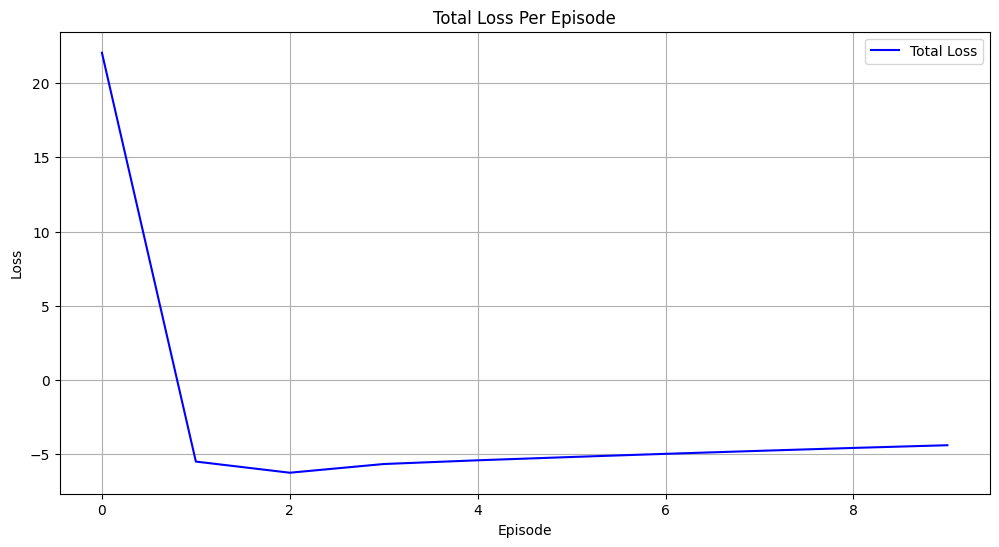

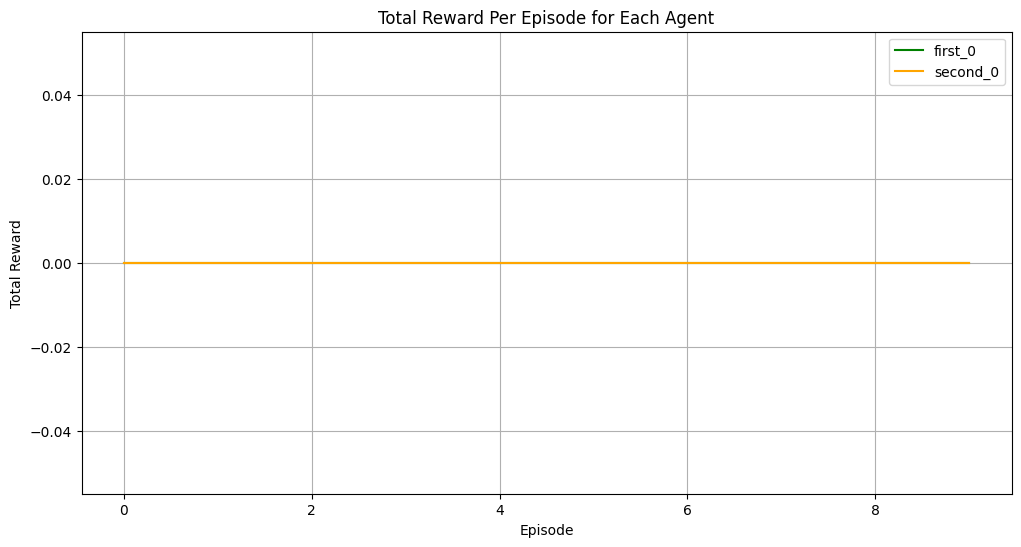

In [14]:
# Plot total loss per episode
plt.figure(figsize=(12, 6))
plt.plot(total_loss_per_episode, label='Total Loss', color='blue')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Total Loss Per Episode')
plt.legend()
plt.grid(True)
plt.show()

# Plot rewards for both agents
plt.figure(figsize=(12, 6))
plt.plot(agent1_rewards, label=parallel_env.agents[0], color='green')
plt.plot(agent2_rewards, label=parallel_env.agents[1], color='orange')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward Per Episode for Each Agent')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
import matplotlib.pyplot as plt
from collections import defaultdict
import time
from numpy.random import normal

# Training parameters
num_episodes = 5
batch_size = 64
max_steps_per_episode = 1000  # maybe 30-45 seconds per 100 steps

# Track total loss and rewards per episode
total_loss_per_episode = []
agent1_rewards = []  # Rewards for the first agent
agent2_rewards = []  # Rewards for the second agent

for episode in range(num_episodes):
    # Start timing the episode
    start_time = time.time()

    obs = parallel_env.reset()
    if isinstance(obs, tuple):
        obs = obs[0]  # Extract observations if returned as a tuple

    done = {agent: False for agent in parallel_env.agents}
    episode_reward = defaultdict(float)  # Store cumulative reward for each agent

    step_count = 0  # Initialize step counter
    episode_policy_loss = 0  # Accumulate policy loss
    episode_value_loss = 0  # Accumulate value loss

    while not all(done.values()) and step_count < max_steps_per_episode:
        actions = {}
        for agent in parallel_env.agents:
            # Preprocess observation
            obs_preprocessed = torch.tensor(obs[agent], dtype=torch.float32)
            if len(obs_preprocessed.shape) > 2:  # Ensure grayscale
                obs_preprocessed = obs_preprocessed.mean(axis=-1)  # Convert RGB to grayscale
            obs_preprocessed = obs_preprocessed.flatten().unsqueeze(0)  # Flatten and add batch dim

            # Get continuous action from Actor
            continuous_action = maddpg.agents[int(agent.split('_')[1])].actor(obs_preprocessed).detach().numpy()
        
            # # Convert continuous action to discrete action
            # discrete_action = np.argmax(continuous_action)  # Take the action with the highest probability
            # actions[agent] = discrete_action  # Store the discrete action for the agent

            # Use Gaussian noise for exploration
            exploration_scale = max(0.1, 0.5 - (episode / num_episodes))  # Cap max exploration at 0.5 (anneal noise)
            exploration_noise = normal(0, exploration_scale, size=continuous_action.shape)
            noisy_action = continuous_action + exploration_noise

            # Convert to discrete action
            discrete_action = np.argmax(noisy_action) # Use noisy action
            actions[agent] = discrete_action

        # # Print actions for debugging
        # print(f"Step {step_count + 1} Actions:")
        # for agent, action in actions.items():
        #     print(f"  {agent}: Action {action}")

        # One-hot encode actions for storage
        actions_one_hot = np.zeros((len(parallel_env.agents), action_dim))
        for idx, agent in enumerate(parallel_env.agents):
            actions_one_hot[idx, actions[agent]] = 1

        # Step the environment
        step_output = parallel_env.step(actions)

        if isinstance(step_output, tuple):  # Handle cases where step returns a tuple
            next_obs, rewards, dones, truncations, infos = step_output
            dones = {agent: dones[agent] or truncations[agent] for agent in dones}
        else:
            next_obs, rewards, dones, infos = step_output

        # Accumulate rewards for each agent
        for agent, reward in rewards.items():
            episode_reward[agent] += reward

        # # Print rewards for debugging
        # print(f"Step {step_count + 1} Rewards:")
        # for agent, reward in rewards.items():
        #     print(f"  {agent}: Reward {reward}")

        # Store data in the replay buffer
        obs_array = []
        next_obs_array = []

        for agent in parallel_env.agents:
            # Preprocess observations for storage
            obs_processed = obs[agent].mean(axis=-1).flatten() if len(obs[agent].shape) > 2 else obs[agent].flatten()
            next_obs_processed = next_obs[agent].mean(axis=-1).flatten() if len(next_obs[agent].shape) > 2 else next_obs[agent].flatten()
            obs_array.append(obs_processed)
            next_obs_array.append(next_obs_processed)

        replay_buffer.store(
            np.array(obs_array),
            actions_one_hot,  # Use one-hot encoded actions
            np.array([rewards[agent] for agent in parallel_env.agents]),
            np.array(next_obs_array),
            np.array([dones[agent] for agent in parallel_env.agents]),
        )

        obs = next_obs

        if replay_buffer.size >= batch_size:
            policy_loss, value_loss = maddpg.update(replay_buffer, batch_size)
            episode_policy_loss += policy_loss
            episode_value_loss += value_loss

        step_count += 1  # Increment step count

    # Record total loss for this episode
    total_loss = episode_policy_loss + episode_value_loss
    total_loss_per_episode.append(total_loss)

    # Separate rewards for each agent
    agent1_reward = episode_reward[parallel_env.agents[0]]
    agent2_reward = episode_reward[parallel_env.agents[1]]

    # Append rewards to lists
    agent1_rewards.append(agent1_reward)
    agent2_rewards.append(agent2_reward)

    # Print cumulative reward and total loss for the episode
    print(f"Episode {episode + 1}/{num_episodes} completed")
    print(f"  {parallel_env.agents[0]} Reward: {agent1_reward}")
    print(f"  {parallel_env.agents[1]} Reward: {agent2_reward}")
    print(f"  Total Loss: {total_loss}")

    # End timing the episode
    end_time = time.time()
    episode_duration = end_time - start_time

    # Print the duration
    print(f"Episode {episode + 1}/{num_episodes} completed in {episode_duration:.2f} seconds")


Episode 1/5 completed
  first_0 Reward: -1.0
  second_0 Reward: 1.0
  Total Loss: 111.26843984736121
Episode 1/5 completed in 236.11 seconds
Episode 2/5 completed
  first_0 Reward: -1.0
  second_0 Reward: 1.0
  Total Loss: 99.66088870690697
Episode 2/5 completed in 247.33 seconds
Episode 3/5 completed
  first_0 Reward: 0.0
  second_0 Reward: 0.0
  Total Loss: 74.32515855293357
Episode 3/5 completed in 242.56 seconds
Episode 4/5 completed
  first_0 Reward: 0.0
  second_0 Reward: 0.0
  Total Loss: 29.26389689889274
Episode 4/5 completed in 244.52 seconds
Episode 5/5 completed
  first_0 Reward: 0.0
  second_0 Reward: 0.0
  Total Loss: 12.344461413360754
Episode 5/5 completed in 244.06 seconds


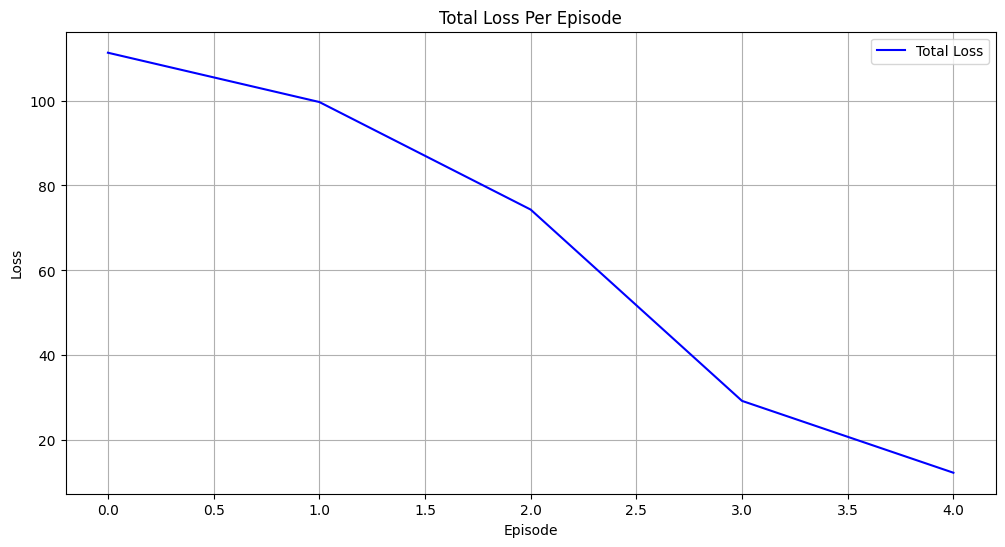

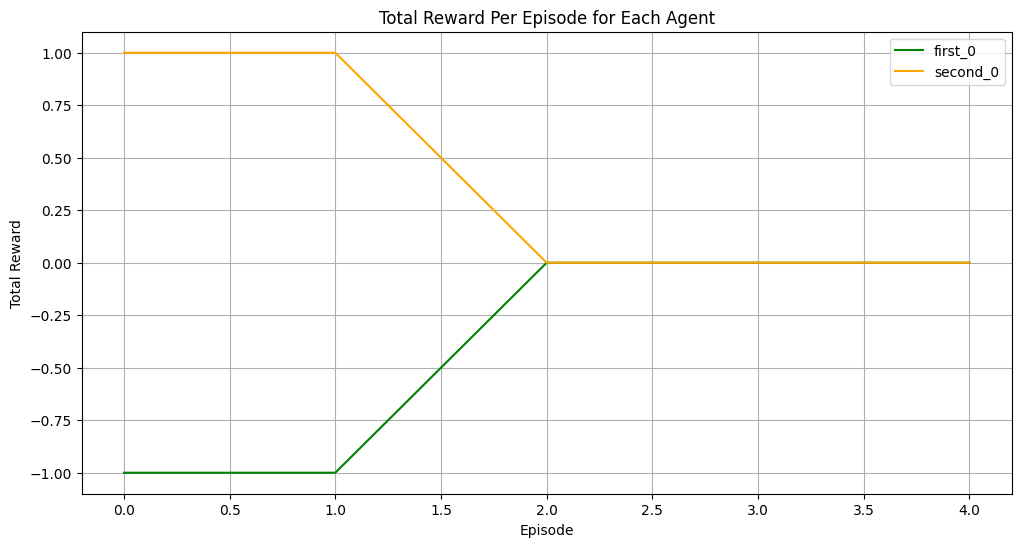

In [17]:
# Plot total loss per episode
plt.figure(figsize=(12, 6))
plt.plot(total_loss_per_episode, label='Total Loss', color='blue')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Total Loss Per Episode')
plt.legend()
plt.grid(True)
plt.show()

# Plot rewards for both agents
plt.figure(figsize=(12, 6))
plt.plot(agent1_rewards, label=parallel_env.agents[0], color='green')
plt.plot(agent2_rewards, label=parallel_env.agents[1], color='orange')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward Per Episode for Each Agent')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
import os

# Directory to save models
save_dir = "maddpg_trained_models_Dec_14_test"
os.makedirs(save_dir, exist_ok=True)

# Save each agent's models
for idx, agent in enumerate(maddpg.agents):
    actor_path = os.path.join(save_dir, f"agent_{idx}_actor.pth")
    critic_path = os.path.join(save_dir, f"agent_{idx}_critic.pth")
    actor_target_path = os.path.join(save_dir, f"agent_{idx}_actor_target.pth")
    critic_target_path = os.path.join(save_dir, f"agent_{idx}_critic_target.pth")
    
    # Save models
    torch.save(agent.actor.state_dict(), actor_path)
    torch.save(agent.critic.state_dict(), critic_path)
    torch.save(agent.actor_target.state_dict(), actor_target_path)
    torch.save(agent.critic_target.state_dict(), critic_target_path)

    print(f"Agent {idx} models saved:")
    print(f"  Actor: {actor_path}")
    print(f"  Critic: {critic_path}")
    print(f"  Actor Target: {actor_target_path}")
    print(f"  Critic Target: {critic_target_path}")


Agent 0 models saved:
  Actor: maddpg_trained_models_Dec_14_test/agent_0_actor.pth
  Critic: maddpg_trained_models_Dec_14_test/agent_0_critic.pth
  Actor Target: maddpg_trained_models_Dec_14_test/agent_0_actor_target.pth
  Critic Target: maddpg_trained_models_Dec_14_test/agent_0_critic_target.pth
Agent 1 models saved:
  Actor: maddpg_trained_models_Dec_14_test/agent_1_actor.pth
  Critic: maddpg_trained_models_Dec_14_test/agent_1_critic.pth
  Actor Target: maddpg_trained_models_Dec_14_test/agent_1_actor_target.pth
  Critic Target: maddpg_trained_models_Dec_14_test/agent_1_critic_target.pth


In [19]:
# Directory to load models from
load_dir = "maddpg_trained_models_Dec_14_test"

# Load each agent's models
for idx, agent in enumerate(maddpg.agents):
    actor_path = os.path.join(load_dir, f"agent_{idx}_actor.pth")
    critic_path = os.path.join(load_dir, f"agent_{idx}_critic.pth")
    actor_target_path = os.path.join(load_dir, f"agent_{idx}_actor_target.pth")
    critic_target_path = os.path.join(load_dir, f"agent_{idx}_critic_target.pth")
    
    # Load models
    agent.actor.load_state_dict(torch.load(actor_path))
    agent.critic.load_state_dict(torch.load(critic_path))
    agent.actor_target.load_state_dict(torch.load(actor_target_path))
    agent.critic_target.load_state_dict(torch.load(critic_target_path))

    print(f"Agent {idx} models loaded:")
    print(f"  Actor: {actor_path}")
    print(f"  Critic: {critic_path}")
    print(f"  Actor Target: {actor_target_path}")
    print(f"  Critic Target: {critic_target_path}")


Agent 0 models loaded:
  Actor: maddpg_trained_models_Dec_14_test/agent_0_actor.pth
  Critic: maddpg_trained_models_Dec_14_test/agent_0_critic.pth
  Actor Target: maddpg_trained_models_Dec_14_test/agent_0_actor_target.pth
  Critic Target: maddpg_trained_models_Dec_14_test/agent_0_critic_target.pth
Agent 1 models loaded:
  Actor: maddpg_trained_models_Dec_14_test/agent_1_actor.pth
  Critic: maddpg_trained_models_Dec_14_test/agent_1_critic.pth
  Actor Target: maddpg_trained_models_Dec_14_test/agent_1_actor_target.pth
  Critic Target: maddpg_trained_models_Dec_14_test/agent_1_critic_target.pth
